In [1]:
import sys
import torch
import tqdm
import numpy as np
import random
import os
import json
sys.path.append('../../')

In [2]:
from models.cnn.search_cnn import  SearchCNN, SearchCNNController
from models.cnn.one_hot_cnn import OneHotSearchCNNController

from configobj import ConfigObj

In [37]:

basecfg_path = '../../configs/hyper/fmnist_hyper_fine_4.cfg'  #конфиг, на который мы ориентируемся при загрузки модели



cfg = ConfigObj(basecfg_path)
name = cfg['name'] # имя для сохранения результатов
ckp_path = '../../searchs/fmnist_hyper_4/best_{}.pth.tar' # это шаблон названия сохраненных моделей
seeds = cfg['seeds'].split(';')  # сиды. можно брать из конфига
cfg['one-hot']['genotype path'] = '../../'+cfg['one-hot']['genotype path']


In [6]:
import utils
# get data with meta info
input_size, input_channels, n_classes, train_data, valid_data = utils.get_data(
    'fashionmnist', '../../data/', cutout_length=0, validation=True)

# split data to train/validation
n_train = len(train_data)
split = int(n_train * 0.5)
indices = list(range(n_train))

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(
    indices[:split])
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(
    indices[split:])

train_loader = torch.utils.data.DataLoader(train_data,
                                        batch_size=64,
                                        sampler=train_sampler,
                                        num_workers=1,
                                        pin_memory=True)
valid_loader = torch.utils.data.DataLoader(train_data,
                                        batch_size=64,
                                        sampler=valid_sampler,
                                        num_workers=1,
                                        pin_memory=True)

test_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=96,
                                           shuffle=False,
                                           num_workers=1,
                                           pin_memory=True)

In [65]:
def fix_structure(sc): # во время тестов нашей модели нужно перейти от непрерывной структуры к one-hot
    for alpha in sc.alpha_reduce:
        alpha.requires_grad = False
        for subalpha in alpha:
            
            argm = torch.argmax(subalpha)
            subalpha.data*=0
            subalpha.data[argm] += 1
    sc.sampling_mode = 'naive'
            
def calc_param_number(sc):
    penalty = 0
    for id, cell in enumerate(sc.net.cells):
            # можно не пробегать несколько раз, т.к. клетки одинаковы (С точностью до normal и reduce)                        
            weights = sc.weights_reduce if cell.reduction else sc.weights_normal
            
            for edges, w_list in zip(cell.dag, weights):
                
                for mixed_op, weights in zip(edges, w_list):
                    for p in mixed_op._ops[weights].parameters():
                    
                        penalty += np.prod(p.shape)
                    
                    
                             
    return penalty            

def calc_param_number_hyper(sc, lam, t=0.2):
    penalty = 0
    for id, cell in enumerate(sc.net.cells):
            # можно не пробегать несколько раз, т.к. клетки одинаковы (С точностью до normal и reduce)                        
            weights = [torch.nn.functional.softmax(alpha(lam)/t) for alpha in sc.hyper_reduce] if cell.reduction else [
                torch.nn.functional.softmax(alpha(lam)/t) for alpha in sc.hyper_normal]        
            
            for edges, w_list in zip(cell.dag, weights):
                for mixed_op, weights in zip(edges, w_list):
                    for op, w in zip(mixed_op._ops, weights):                        
                        for param in op.parameters():
                            penalty += w*np.prod(param.shape) 
    return penalty
calc_param_number(sc)

73296

In [73]:
# смотрим качество модели, которое мы получили на обучении, без фиксации структуры
param_num = {}
acc = {}
cfg['device'] = 'cuda'    
for lam, ckp_path in [('1e-08', '../../searchs/fmnist_hyper_8/best_{}.pth.tar'), 
                      ('1e-06',  '../../searchs/fmnist_hyper_6/best_{}.pth.tar'),
            ('0.0001', '../../searchs/fmnist_hyper_4/best_{}.pth.tar')]:   
    param_num[lam] = []
    acc[lam] = []
    for s in seeds:
        
        cfg['one-hot']['genotype path'] = '../../searchs/fmnist_darts_hypernet/genotype_{}_{}.json'.format(s, lam)
        cfg['seed'] = s
        sc = OneHotSearchCNNController(**cfg)
        
        sc.load_state_dict(torch.load(ckp_path.format(s)))
        print (ckp_path.format(s))
        sc = sc.to('cuda')
        sc.eval()
        
           
        print ('seed {}, lam: {}'.format(s, lam))

        correct = 0
        total = 0
        for x,y in tqdm.tqdm(test_loader):
            x = x.cuda()
            y = y.cuda()
            out = sc(x)
            correct += torch.eq(torch.argmax(out, 1), y).sum()
            total += len(x)
        print (correct*1.0/total*1.0)
        print (calc_param_number(sc))
        param_num[lam].append(calc_param_number(sc))
        acc[lam].append(correct*1.0/total*1.0)

  0%|          | 0/105 [00:00<?, ?it/s]

../../searchs/fmnist_hyper_8/best_0.pth.tar
seed 0, lam: 1e-08


100%|██████████| 105/105 [00:01<00:00, 81.68it/s]


tensor(0.9475, device='cuda:0')
418752


  0%|          | 0/105 [00:00<?, ?it/s]

../../searchs/fmnist_hyper_8/best_13.pth.tar
seed 13, lam: 1e-08


100%|██████████| 105/105 [00:01<00:00, 81.65it/s]


tensor(0.9453, device='cuda:0')
342144


  0%|          | 0/105 [00:00<?, ?it/s]

../../searchs/fmnist_hyper_8/best_21.pth.tar
seed 21, lam: 1e-08


100%|██████████| 105/105 [00:01<00:00, 81.56it/s]


tensor(0.9459, device='cuda:0')
379296


  0%|          | 0/105 [00:00<?, ?it/s]

../../searchs/fmnist_hyper_6/best_0.pth.tar
seed 0, lam: 1e-06


100%|██████████| 105/105 [00:01<00:00, 82.43it/s]


tensor(0.9460, device='cuda:0')
310608


  0%|          | 0/105 [00:00<?, ?it/s]

../../searchs/fmnist_hyper_6/best_13.pth.tar
seed 13, lam: 1e-06


100%|██████████| 105/105 [00:01<00:00, 82.74it/s]


tensor(0.9462, device='cuda:0')
239616


  0%|          | 0/105 [00:00<?, ?it/s]

../../searchs/fmnist_hyper_6/best_21.pth.tar
seed 21, lam: 1e-06


100%|██████████| 105/105 [00:01<00:00, 81.40it/s]


tensor(0.9463, device='cuda:0')
399024


  0%|          | 0/105 [00:00<?, ?it/s]

../../searchs/fmnist_hyper_4/best_0.pth.tar
seed 0, lam: 0.0001


100%|██████████| 105/105 [00:01<00:00, 82.89it/s]


tensor(0.8885, device='cuda:0')
11520


  0%|          | 0/105 [00:00<?, ?it/s]

../../searchs/fmnist_hyper_4/best_13.pth.tar
seed 13, lam: 0.0001


100%|██████████| 105/105 [00:01<00:00, 81.99it/s]


tensor(0.9366, device='cuda:0')
73296


  0%|          | 0/105 [00:00<?, ?it/s]

../../searchs/fmnist_hyper_4/best_21.pth.tar
seed 21, lam: 0.0001


100%|██████████| 105/105 [00:01<00:00, 82.85it/s]

tensor(0.9207, device='cuda:0')
30240


In [71]:
param_num

{'0': [11520], '13': [73296], '21': [30240]}

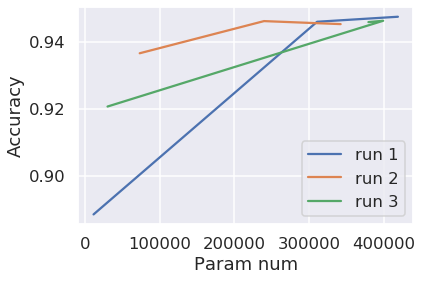

In [80]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
sns.set('talk')
for i in range(3):
    plt.plot([param_num[k][i] for k in ['1e-08', '1e-06', '0.0001']][::-1],  [acc[k][i] for k in ['1e-08', '1e-06', '0.0001']][::-1] , label='run '+str(i+1))
plt.xlabel('Param num')
plt.ylabel('Accuracy')
plt.legend(loc='best')

In [75]:
[param_num[k][i] for k in ['1e-08', '1e-06', '0.0001']]

[379296, 399024, 30240]

In [36]:
import json
cfg = ConfigObj(basecfg_path)
cfg['device'] = 'cuda'
sc = SearchCNNControllerWithHyperNet(**cfg)    

for s in seeds:
    sc.load_state_dict(torch.load(ckp_path.format(s)))
    sc = sc.to('cuda')
    sc.eval()
    sc2 = SearchCNNController(**cfg)
    for lam_ in [-8, -6, -4]:
        lam_ = 10.0**(lam_)
        lam = torch.tensor([lam_]).to('cuda')
        
        for h,a in zip(sc.hyper_reduce, sc2.alpha_reduce):
            a.data = torch.clone((h(sc.norm_lam(lam)) )) 
        for h,a in zip(sc.hyper_normal, sc2.alpha_normal):
            a.data = torch.clone((h(sc.norm_lam(lam)) )) 
        fix_structure(sc2)
        print (s, lam_, calc_param_number(sc2))
        structure_list_reduce = []
        structure_list_normal = []
        for a in sc2.alpha_reduce:
            structure_list_reduce.append((torch.argmax(a, 1).cpu().detach().numpy()).tolist())
        for a in sc2.alpha_normal:
            structure_list_normal.append((torch.argmax(a, 1).cpu().detach().numpy()).tolist())    
        with open('../../searchs/fmnist_darts_hypernet/genotype_{}_{}.json'.format(s, lam_), 'w') as out:
            out.write(json.dumps([structure_list_reduce, structure_list_normal]))

0 1e-08 tensor(17856., device='cuda:0')
0 1e-06 tensor(13008., device='cuda:0')
0 0.0001 tensor(256., device='cuda:0')
13 1e-08 tensor(13440., device='cuda:0')
13 1e-06 tensor(9216., device='cuda:0')
13 0.0001 tensor(3024., device='cuda:0')
21 1e-08 tensor(15520., device='cuda:0')
21 1e-06 tensor(16688., device='cuda:0')
21 0.0001 tensor(1312., device='cuda:0')


In [9]:
import json
cfg = ConfigObj(basecfg_path)
cfg['device'] = 'cuda'
sc = SearchCNNControllerWithHyperNet(**cfg)    

for s in seeds:        
    sc2 = SearchCNNController(**cfg)
    sc2.load_state_dict(torch.load('../../searchs/fmnist_darts/best_{}.pth.tar'.format(s)))
    
    fix_structure(sc2)
    print (calc_param_number(sc2))
    structure_list_reduce = []
    structure_list_normal = []
    for a in sc2.alpha_reduce:
        structure_list_reduce.append((torch.argmax(a, 1).cpu().detach().numpy()).tolist())
    for a in sc2.alpha_normal:
        structure_list_normal.append((torch.argmax(a, 1).cpu().detach().numpy()).tolist())    
    with open('../../searchs/fmnist_darts/genotype_{}.json'.format(s), 'w') as out:
        out.write(json.dumps([structure_list_reduce, structure_list_normal]))

tensor(12496.)
tensor(12352.)
tensor(13120.)


In [9]:
# смотрим качество модели и количество параметров модели, которое мы получили на обучении (но с фиксацией структуры!)
cfg = ConfigObj(basecfg_path)
cfg['device'] = 'cuda'
for lam_ in range(-8, -3):
    lam_ = 10.0**(lam_)
    lam = torch.tensor([lam_])
    for s in seeds:
       
        sc0 = SearchCNNControllerWithHyperNet(**cfg)        
        sc0.load_state_dict(torch.load(ckp_path.format(s)))     
        
        sc = SearchCNNController(**cfg)
        sc.net.load_state_dict(sc0.net.state_dict(), strict=False)     
        sc.net.linear.weight.data = sc0.net.linear.weight.data * sc0.norm_lam(lam) + sc0.net.linear2.weight.data * (1.0-sc0.norm_lam(lam)) 
        sc.net.linear.bias.data = sc0.net.linear.bias.data * sc0.norm_lam(lam) + sc0.net.linear2.bias.data * (1.0-sc0.norm_lam(lam)) 
        
        for h,a in zip(sc0.hyper_reduce, sc.alpha_reduce):
            a.data = torch.clone((h(sc0.norm_lam(lam)) ))        
        sc = sc.to('cuda')        
        fix_structure(sc)
        sc.eval()
        correct = 0
        total = 0
        for x,y in tqdm.tqdm(valid_loader):
            x = x.cuda()
            y = y.cuda()
            out = sc(x)
            correct += torch.eq(torch.argmax(out, 1), y).sum()
            total += len(x)
        
        penalty = calc_param_number(sc)        
        print ('seed {}, lam: {}'.format(s, lam_))
        print (correct*1.0/total*1.0)
        print ('param num', penalty)
        print ('\n'*3)
                            
        

100%|██████████| 469/469 [00:11<00:00, 41.39it/s]


seed 0, lam: 1e-08
tensor(0.1803, device='cuda:0')
param num tensor(5136., device='cuda:0')






100%|██████████| 469/469 [00:10<00:00, 42.80it/s]


seed 13, lam: 1e-08
tensor(0.1537, device='cuda:0')
param num tensor(5392., device='cuda:0')






100%|██████████| 469/469 [00:11<00:00, 42.56it/s]


seed 21, lam: 1e-08
tensor(0.1014, device='cuda:0')
param num tensor(4992., device='cuda:0')






100%|██████████| 469/469 [00:11<00:00, 42.26it/s]


seed 0, lam: 1e-07
tensor(0.1876, device='cuda:0')
param num tensor(5136., device='cuda:0')






100%|██████████| 469/469 [00:10<00:00, 42.83it/s]


seed 13, lam: 1e-07
tensor(0.1359, device='cuda:0')
param num tensor(4080., device='cuda:0')






100%|██████████| 469/469 [00:11<00:00, 42.24it/s]


seed 21, lam: 1e-07
tensor(0.1013, device='cuda:0')
param num tensor(5248., device='cuda:0')






100%|██████████| 469/469 [00:10<00:00, 42.97it/s]


seed 0, lam: 1e-06
tensor(0.1930, device='cuda:0')
param num tensor(5136., device='cuda:0')






100%|██████████| 469/469 [00:10<00:00, 42.84it/s]


seed 13, lam: 1e-06
tensor(0.1351, device='cuda:0')
param num tensor(4080., device='cuda:0')






100%|██████████| 469/469 [00:10<00:00, 42.80it/s]


seed 21, lam: 1e-06
tensor(0.1009, device='cuda:0')
param num tensor(5248., device='cuda:0')






100%|██████████| 469/469 [00:10<00:00, 42.97it/s]


seed 0, lam: 1e-05
tensor(0.2060, device='cuda:0')
param num tensor(3824., device='cuda:0')






100%|██████████| 469/469 [00:11<00:00, 42.23it/s]


seed 13, lam: 1e-05
tensor(0.1343, device='cuda:0')
param num tensor(4080., device='cuda:0')






100%|██████████| 469/469 [00:10<00:00, 42.84it/s]


seed 21, lam: 1e-05
tensor(0.1015, device='cuda:0')
param num tensor(5248., device='cuda:0')






100%|██████████| 469/469 [00:11<00:00, 42.22it/s]


seed 0, lam: 0.0001
tensor(0.2083, device='cuda:0')
param num tensor(3824., device='cuda:0')






100%|██████████| 469/469 [00:10<00:00, 43.25it/s]


seed 13, lam: 0.0001
tensor(0.1325, device='cuda:0')
param num tensor(4080., device='cuda:0')






100%|██████████| 469/469 [00:10<00:00, 42.88it/s]


seed 21, lam: 0.0001
tensor(0.1012, device='cuda:0')
param num tensor(5248., device='cuda:0')






In [ ]:
# попробуем дообучить модельки с GS при фиксированной лямбде
cfg = ConfigObj(basecfg_path)
cfg['device'] = 'cuda'
for lam_ in range(-8, -3):
    lam_ = 10.0**(lam_)
    lam = torch.tensor([[lam_]]).cuda()
    for s in seeds:
       
        sc0 = SearchCNNControllerWithHyperNet(**cfg)        
        sc0.load_state_dict(torch.load(ckp_path.format(s)))     
        sc0 = sc0.to('cuda')
        sc0.samling_mode='gumbel-softmax'
        
        
        batch_id = 0
        for e in range(fine_epochs//2):
            tq = tqdm.tqdm((zip(train_loader, valid_loader)))
            losses = []
            for ((trn_X, trn_y), (val_X, val_y)) in tq:
                batch_id += 1                
                t = 0.2 + (0.8 - 0.8 * batch_id/(fine_epochs//2*len(train_loader)))
                sc0.t = t
                trn_X, trn_y = trn_X.to('cuda', non_blocking=True), trn_y.to('cuda', non_blocking=True)
                val_X, val_y = val_X.to('cuda', non_blocking=True), val_y.to('cuda', non_blocking=True)        
                loss = sc0.train_step(trn_X, trn_y, val_X, val_y, lam).detach().cpu().numpy()
                losses.append(loss)
                tq.set_description('{};{}'.format(sc0.t, str(np.mean(losses))))
                

    
        
    
        sc = SearchCNNController(**cfg).to('cuda')
        sc.net.load_state_dict({k:v for k,v in sc0.net.state_dict().items() if not k.startswith('linear')}, strict=False)     
        sc.net.linear.weight.data = sc0.net.linear.weight.data * sc0.norm_lam(lam.cuda()) + sc0.net.linear2.weight.data * (1.0-sc0.norm_lam(lam.cuda())) 
        sc.net.linear.bias.data = sc0.net.linear.bias.data * sc0.norm_lam(lam.cuda()) + sc0.net.linear2.bias.data * (1.0-sc0.norm_lam(lam.cuda())) 
        
        for h,a in zip(sc0.hyper_reduce, sc.alpha_reduce):
            a.data = torch.clone((h(sc0.norm_lam(lam.cuda())) ))        
        sc = sc.to('cuda')        
        fix_structure(sc)
        sc.eval()
        correct = 0
        total = 0
        
        for x,y in tqdm.tqdm(valid_loader):
            x = x.cuda()
            y = y.cuda()
            out = sc(x)
            correct += torch.eq(torch.argmax(out, 1), y).sum()
            total += len(x)
        
        penalty = calc_param_number(sc)        
        print ('seed {}, lam: {}'.format(s, lam_))
        print (correct*1.0/total*1.0)
        print ('param num', penalty)
        print ('\n'*3)
        torch.save(sc0.state_dict(), 'model_{}_prefine_lam_{}.pth'.format(s, lam_ ))
                            
        

0.8400000000000001;0.4043188: : 469it [02:12,  3.55it/s] 
0.6799999999999999;0.39249295: : 469it [02:12,  3.53it/s]
0.52;0.41450283: : 469it [02:12,  3.53it/s]              
0.35999999999999993;0.47854024: : 469it [02:13,  3.52it/s]
0.2;0.5066623: : 469it [02:13,  3.52it/s]                 
100%|██████████| 469/469 [00:11<00:00, 42.10it/s]


seed 0, lam: 1e-08
tensor(0.8107, device='cuda:0')
param num tensor(5536., device='cuda:0')






0.8400000000000001;0.40814236: : 469it [02:14,  3.48it/s]
0.6799999999999999;0.41312867: : 469it [02:13,  3.51it/s]
0.52;0.47623208: : 469it [02:13,  3.51it/s]              
0.35999999999999993;0.53664: : 469it [02:13,  3.50it/s]   
0.2;0.53781337: : 469it [02:13,  3.51it/s]                
100%|██████████| 469/469 [00:11<00:00, 42.12it/s]


seed 13, lam: 1e-08
tensor(0.7943, device='cuda:0')
param num tensor(4624., device='cuda:0')






0.8400000000000001;0.412834: : 469it [02:14,  3.49it/s]  
0.6799999999999999;0.39535308: : 469it [02:13,  3.50it/s]
0.52;0.4488344: : 469it [02:13,  3.51it/s]               
0.35999999999999993;0.5712375: : 469it [02:14,  3.50it/s] 
0.2;0.57487947: : 469it [02:14,  3.50it/s]                
100%|██████████| 469/469 [00:11<00:00, 42.50it/s]


seed 21, lam: 1e-08
tensor(0.7800, device='cuda:0')
param num tensor(2368., device='cuda:0')






0.8400000000000001;0.4046444: : 469it [02:14,  3.50it/s] 
0.6799999999999999;0.39429826: : 469it [02:14,  3.50it/s]
0.52;0.435625: : 469it [02:14,  3.49it/s]                
0.35999999999999993;0.49148074: : 469it [02:14,  3.49it/s]
0.2;0.48702675: : 469it [02:14,  3.49it/s]                
100%|██████████| 469/469 [00:11<00:00, 41.98it/s]


seed 0, lam: 1e-07
tensor(0.8186, device='cuda:0')
param num tensor(5536., device='cuda:0')






0.8400000000000001;0.4104831: : 469it [02:15,  3.47it/s] 
0.6799999999999999;0.4086935: : 469it [02:14,  3.49it/s] 
0.52;0.4882927: : 469it [02:14,  3.49it/s]               
0.35999999999999993;0.5656745: : 469it [02:14,  3.49it/s] 
0.2;0.57952523: : 469it [02:14,  3.49it/s]                
100%|██████████| 469/469 [00:11<00:00, 42.32it/s]


seed 13, lam: 1e-07
tensor(0.7696, device='cuda:0')
param num tensor(2768., device='cuda:0')






0.8400000000000001;0.40220574: : 469it [02:15,  3.46it/s]
0.6799999999999999;0.39326245: : 469it [02:14,  3.50it/s]
0.52;0.4555588: : 469it [02:14,  3.49it/s]               
0.35999999999999993;0.52977747: : 469it [02:14,  3.49it/s]
0.2;0.56830007: : 469it [02:14,  3.49it/s]                
100%|██████████| 469/469 [00:11<00:00, 42.39it/s]


seed 21, lam: 1e-07
tensor(0.7992, device='cuda:0')
param num tensor(3280., device='cuda:0')






0.8400000000000001;0.40011162: : 469it [02:14,  3.48it/s]
0.6799999999999999;0.3999156: : 469it [02:14,  3.50it/s] 
0.52;0.45893353: : 469it [02:14,  3.49it/s]              
0.35999999999999993;0.4908115: : 469it [02:14,  3.49it/s] 
0.2;0.4823559: : 469it [02:14,  3.50it/s]                 
100%|██████████| 469/469 [00:11<00:00, 42.48it/s]


seed 0, lam: 1e-06
tensor(0.8139, device='cuda:0')
param num tensor(5536., device='cuda:0')






0.8400000000000001;0.40802523: : 469it [02:13,  3.51it/s]
0.6799999999999999;0.4077734: : 469it [02:13,  3.50it/s] 
0.52;0.49071798: : 469it [02:14,  3.49it/s]              
0.35999999999999993;0.53119177: : 469it [02:14,  3.49it/s]
0.2;0.5189696: : 469it [02:14,  3.49it/s]                 
100%|██████████| 469/469 [00:11<00:00, 41.85it/s]


seed 13, lam: 1e-06
tensor(0.8030, device='cuda:0')
param num tensor(5024., device='cuda:0')






0.8400000000000001;0.4033742: : 469it [02:15,  3.47it/s] 
0.6799999999999999;0.4110306: : 469it [02:14,  3.50it/s] 
0.52;0.5326376: : 469it [02:14,  3.50it/s]               
0.35999999999999993;0.63631976: : 469it [02:14,  3.48it/s]
0.2;0.64182293: : 469it [02:14,  3.50it/s]                
100%|██████████| 469/469 [00:11<00:00, 42.09it/s]


seed 21, lam: 1e-06
tensor(0.7621, device='cuda:0')
param num tensor(1712., device='cuda:0')






0.8400000000000001;0.39981738: : 469it [02:15,  3.46it/s]
0.6799999999999999;0.41133812: : 469it [02:13,  3.50it/s]
0.52;0.4694031: : 469it [02:14,  3.49it/s]               
0.35999999999999993;0.49344125: : 469it [02:14,  3.49it/s]
0.2;0.49546286: : 469it [02:14,  3.49it/s]                
100%|██████████| 469/469 [00:11<00:00, 42.25it/s]


seed 0, lam: 1e-05
tensor(0.8205, device='cuda:0')
param num tensor(5136., device='cuda:0')






0.8400000000000001;0.40587115: : 469it [02:13,  3.51it/s]
0.6799999999999999;0.43235728: : 469it [02:14,  3.50it/s]
0.5851599147121536;0.50316465: : 278it [01:19,  3.52it/s]

In [48]:
sc.net.load_state_dict({k:v for k,v in sc0.net.state_dict().items() if not k.startswith('linear')}, strict=False)     

_IncompatibleKeys(missing_keys=['linear.weight', 'linear.bias'], unexpected_keys=[])

In [75]:
sc0.load_state_dict(torch.load('model_{}_prefine_lam_{}.pth'.format(21, 1e-05)))

#sc0.load_state_dict(torch.load(ckp_path.format(21)))

<All keys matched successfully>

In [78]:
sc.net.load_state_dict({k:v for k,v in sc0.net.state_dict().items() if not k.startswith('linear')}, strict=False)     

_IncompatibleKeys(missing_keys=['linear.weight', 'linear.bias'], unexpected_keys=[])

In [81]:
4192*1e-4

0.4192

In [74]:
for a in sc.alpha_reduce:
    print (a)

Parameter containing:
tensor([[-0.6793, -0.8374,  0.0809, -0.2418,  0.5758,  0.0916, -0.6825,  2.2758],
        [-0.6861, -0.7966, -0.4870, -0.3345, -0.2127,  0.4595,  0.5867,  1.7800]],
       device='cuda:0')
Parameter containing:
tensor([[-0.7620, -0.2313, -0.5894,  0.2517, -0.6279,  0.4361, -0.3550,  2.0233],
        [-0.5545, -0.2676, -0.4321,  0.0770, -0.4739,  0.1332, -0.2282,  2.0525],
        [ 0.6882, -0.0700,  0.4858,  0.0176, -0.0161, -0.2411, -0.0498,  1.1780]],
       device='cuda:0')
Parameter containing:
tensor([[-0.3577,  0.4244, -0.5864, -0.4812,  0.4161, -0.5056, -0.6018,  1.4522],
        [-0.4509, -0.2380,  0.6548, -0.4999, -0.3036, -0.1844, -0.4880,  1.4063],
        [-0.2787, -0.1226,  0.3400, -0.6762,  0.6923, -0.2661, -0.5475,  1.1888],
        [-0.2631, -0.1943,  0.1652,  0.0118,  0.0536,  0.3022, -0.7372,  1.1762]],
       device='cuda:0')
Parameter containing:
tensor([[ 0.1350,  0.3346, -0.1099, -0.4033, -0.7179, -0.1483, -0.4896,  1.4195],
        [-0.1266,

In [70]:
for a in sc.alpha_reduce:
    print (a)

Parameter containing:
tensor([[-1.2752, -1.1633, -0.0377,  0.1065,  0.7666, -0.2744, -1.3294,  2.5319],
        [-1.5961, -1.8689, -1.5031, -0.8603, -0.8925, -0.4113,  1.9811,  0.3283]],
       device='cuda:0')
Parameter containing:
tensor([[-0.8614, -0.6020, -0.7579, -0.7302, -0.4433,  0.2239, -0.6985,  2.8633],
        [-1.0295, -1.1201, -0.5128, -0.3750, -0.7249,  0.1413,  0.1304,  2.8212],
        [ 1.6851,  0.0339, -0.2289, -0.5038,  0.0593, -0.9414, -0.6293, -0.3387]],
       device='cuda:0')
Parameter containing:
tensor([[-0.2573,  0.3016, -1.4422, -0.4495,  1.7029, -1.4176, -1.6134, -0.3078],
        [-1.0416, -1.0655,  0.8919, -0.0287, -0.5155, -0.6061, -0.5152,  2.1735],
        [-0.9524, -0.7642, -0.4555, -0.9560,  2.0914, -1.2969, -1.5526,  0.4531],
        [-0.7527, -0.7405, -0.2592,  0.4203, -0.6379,  0.3502, -1.2180,  2.3595]],
       device='cuda:0')
Parameter containing:
tensor([[-0.1654, -0.6048, -0.7071, -0.1080, -1.0438, -0.3818,  0.0310,  2.1932],
        [-1.1209,

In [33]:
lam_ = 1.0
for h,a in zip(sc0.hyper_reduce, sc.alpha_reduce):
                a.data = torch.clone(h(torch.tensor([lam_]).cuda()) )
       
fix_structure(sc)
for a in sc.alpha_reduce:
    print (a)

Parameter containing:
tensor([[-0., -0., 0., -0., 0., 0., -0., 1.],
        [-0., -0., -0., -0., -0., 0., 0., 1.]], device='cuda:0')
Parameter containing:
tensor([[-0., -0., -0., 0., -0., 0., -0., 1.],
        [-0., -0., -0., 0., -0., 0., -0., 1.],
        [0., -0., 0., 0., -0., -0., -0., 1.]], device='cuda:0')
Parameter containing:
tensor([[-0., 0., -0., -0., 0., -0., -0., 1.],
        [-0., -0., 0., -0., -0., -0., -0., 1.],
        [-0., -0., 0., -0., 0., -0., -0., 1.],
        [-0., -0., 0., -0., 0., 0., -0., 1.]], device='cuda:0')
Parameter containing:
tensor([[0., 0., -0., -0., -0., -0., -0., 1.],
        [-0., -0., -0., -0., -0., -0., -0., 1.],
        [0., 0., 0., -0., 0., -0., -0., 1.],
        [0., 0., 0., -0., -0., -0., -0., 1.],
        [1., 0., -0., -0., 0., 0., -0., -0.]], device='cuda:0')


In [11]:
import torch.nn.functional as F
def hyperloss(self, X, y, lam):
        #logits = self.forward(X, lam)
        penalty = 0
        
        for id, cell in enumerate(self.net.cells):
            # можно не пробегать несколько раз, т.к. клетки одинаковы (С точностью до normal и reduce)            
            
            lam_ = self.norm_lam(lam)
            weights = [alpha(lam_) for alpha in self.hyper_reduce] if cell.reduction else [
                alpha(lam_) for alpha in self.hyper_normal]
            
            weights = [F.softmax(w/self.t, dim=-1) for w in weights]
            
              
            for edges, w_list in zip(cell.dag, weights):
                for mixed_op, weights in zip(edges, w_list):
                    for op, w in zip(mixed_op._ops, weights):                        
                        for param in op.parameters():
                            penalty += w*np.prod(param.shape)          
            #penalty += lam_[0,0] * (torch.norm(self.net.linear.weight)**2 + torch.norm(self.net.linear.bias)**2)
            #penalty += (1.0-lam_[0,0]) * (torch.norm(self.net.linear2.weight)**2 + torch.norm(self.net.linear2.bias)**2)
            

        # oleg return self.criterion(logits, y)   + penalty * lam[0,0] 
        return penalty 
    

In [14]:
sc0 = sc0.cuda()
sc0.t = 0.1

In [15]:
for r in range(-10, -4):
    
    print (hyperloss(sc0, 0, 0, torch.tensor([[10**r]]).cuda()))

tensor(6328.6978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5707.0322, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5262.7612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4670.6914, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3872.0901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3365.1294, device='cuda:0', grad_fn=<AddBackward0>)


'64'

In [14]:
sc0.hyper_reduce[0].model[0].weight, sc0.hyper_reduce[0].model[0].bias

(Parameter containing:
 tensor([[ 1.1084],
         [-0.0756],
         [-0.0762],
         [-0.0475],
         [-0.6884],
         [-0.0391],
         [-0.0297],
         [-0.0831],
         [ 1.0998],
         [-0.0604],
         [-0.0712],
         [-0.0253],
         [-0.6183],
         [-0.0505],
         [-0.0459],
         [-0.0997]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 1.5646, -0.8272, -0.6284, -0.3190,  1.9144, -0.6870, -0.3635, -1.1838,
          1.3121, -0.8585, -0.7832,  0.6159,  1.7367, -0.8624, -0.6465, -1.3189],
        device='cuda:0', requires_grad=True))

In [29]:
for lam_ in [-4.0,  -1.0]:
        lam = torch.tensor([10**lam_])
        # создаем модель с обязательным указанием, что к структуре не применяется softmax
        cfg = ConfigObj(basecfg_path)
        cfg['darts']['sampling_mode'] = 'naive' 
        cfg['device'] = 'cuda'    
        for s in seeds:
            print (s)
            sc0 = SearchCNNControllerWithHyperNet(**cfg)        
            sc0.load_state_dict(torch.load(ckp_path.format(s)))                            
            sc = SearchCNNController(**cfg)
            
            sc.net.load_state_dict(sc0.net.state_dict())
            for h,a in zip(sc0.hyper_reduce, sc.alpha_reduce):
                a.data = torch.clone(h(lam))                                            
            fix_structure(sc)
            
            sc = sc.to('cuda')
            optim = torch.optim.Adam(sc.weights())
            correct = 0
            total = 0
            # дообучаем n эпох
            print ('seed {}, lam: {}'.format(s, lam_))
            for e in range(5):
                for x,y in tqdm.tqdm(train_loader):
                    x = x.cuda()
                    y = y.cuda()            
                    optim.zero_grad()
                    loss = sc.loss(x,y)
                    loss.backward()
                    optim.step()                              
                
                sc.eval()
                correct = 0
                total = 0
                for x,y in tqdm.tqdm(valid_loader):
                    x = x.cuda()
                    y = y.cuda()
                    out = sc(x)
                    correct += torch.eq(torch.argmax(out, 1), y).sum()
                    total += len(x)
                print (correct*1.0/total*1.0)
                sc.train()
            torch.save(sc.state_dict(), ckp_path.format(s)+'{}.fine'.format(lam_))

0


  0%|          | 0/938 [00:00<?, ?it/s]

seed 0, lam: -4.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  3%|▎         | 27/938 [00:02<01:27, 10.43it/s]


KeyboardInterrupt: 

In [34]:
# смотрим качество модели, которое мы получили на обучении
cfg = ConfigObj(basecfg_path)
cfg['device'] = 'cuda'
for lam_ in [-4.0,  -1.0]:
    for s in seeds:
        print ('seed {}, lam: {}'.format(s, lam_))
        sc = SearchCNNController(**cfg)
        
        sc.load_state_dict(torch.load(ckp_path.format(s)+'{}.fine'.format(lam_)))
        
        sc = sc.to('cuda')
        sc.eval()
        correct = 0
        total = 0
        for x,y in tqdm.tqdm(valid_loader):
            x = x.cuda()
            y = y.cuda()
            out = sc(x)
            correct += torch.eq(torch.argmax(out, 1), y).sum()
            total += len(x)
        print (correct*1.0/total*1.0)

  0%|          | 0/157 [00:00<?, ?it/s]

seed 21, lam: -4.0


  0%|          | 0/157 [00:00<?, ?it/s]

tensor(0.0960, device='cuda:0')
seed 21, lam: -1.0


100%|██████████| 157/157 [00:03<00:00, 44.67it/s]

tensor(0.0967, device='cuda:0')


ParameterList(
    (0): Parameter containing: [torch.FloatTensor of size 2x8]
    (1): Parameter containing: [torch.FloatTensor of size 3x8]
    (2): Parameter containing: [torch.FloatTensor of size 4x8]
    (3): Parameter containing: [torch.FloatTensor of size 5x8]
)